<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/Clean_DeepPit_1a_Voxelmorph_ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
from pathlib import Path 

ROOT = "/content/drive"    
drive.mount(ROOT)

# Useful paths
PROJ_PATH            = Path(ROOT)/"My Drive/PitProj/"

Mounted at /content/drive


# Voxelmorph ROI

Align an unlabelled MR to a labelled MR/CT (via pre-trained voxelmoprh) in order to generate ROI for the unlabelled MR.

Sources: 

- MR Atlas and labels: from https://github.com/voxelmorph/voxelmorph/tree/master/data/

- Voxelmorph Tutorial: https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing#scrollTo=UCw0avYgPXMd

- Kaggle https://www.kaggle.com/kmader/voxelmorph-on-ct-data#Load-Atlas-Data

- Kaggle https://www.kaggle.com/kmader/voxelmorph-demo

# Imports

In [7]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 

# to read CT dcm files
!pip install pydicom

# to resize physical attr of CT such as Slice Thicnkess
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 132kB/s 


In [ ]:
# imports
import os, sys

# third party imports
import numpy as np
import nibabel as nib

import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm # deep-learning based registration library
import neurite    as ne # medical image analysis with tensorflow

# plot
import matplotlib.pyplot as plt

# Load CT

About:
- TCIA: manifest-1614720733774
- ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-039
- 01-11-1960-PET RESEARCH-94533
- 3.000000-CT 2.5MM STD-12405

Format:
- Folder containing DICOM files. 

In [34]:
# from https://www.kaggle.com/kmader/voxelmorph-on-ct-data

# imports
import SimpleITK as sitk
import scipy.io as sio

from scipy.ndimage import zoom
from scipy.interpolate import interpn

# Get path to dcm files
ct_ds_name = "manifest-1614720733774/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-039/01-11-1960-PET RESEARCH-94533/3.000000-CT 2.5MM STD-12405"
ct_folder = os.path.join(PROJ_PATH, ct_ds_name)

# compile CT obj from dcm files using Simple ITK reader
series_reader = sitk.ImageSeriesReader()
dcm_paths     = series_reader.GetGDCMSeriesFileNames(ct_folder)
ct_obj        = sitk.ReadImage(dcm_paths)
ct_vol        = sitk.GetArrayFromImage(ct_obj)

print(f"DCM files in folder: {len(dcm_paths)}")
print(f"CT vol shape: {ct_vol.shape}")
print(f"CT metadata: ", [ct_obj.GetMetaData(k) for k in ct_obj.GetMetaDataKeys()])

ct_vox_size = np.array(ct_obj.GetSpacing()[::-1]) # reverse array?
n_vox_size = np.mean(ct_vox_size)
iso_ct_vol = zoom(ct_vol, ct_vox_size/n_vox_size)[::-1] # reverse array?
print(f"Vox size: {ct_vox_size}, mean: {n_vox_size}.")
print(f"Isotropic (1,1,1)mm CT shape: {iso_ct_vol.shape}")

# rescale dimensions to (192, 256, 256)
vol_size = (192, 256, 256)

old_shape = np.array(iso_ct_vol.shape)
new_shape = np.array(vol_size)
reshaped_ct_vol = zoom(iso_ct_vol, new_shape/old_shape)

print(f"Reshaped CT vol (isotropic + reshaped) shape: {reshaped_ct_vol.shape}")

DCM files in folder: 62
CT vol shape: (62, 512, 512)
Slice metadata:  ['[UNKNOWN_PRINT_CHARACTERISTICS]\n']
Vox size: [2.5      0.492188 0.492188], mean: 1.1614586666666666.
Isotropic (1,1,1)mm CT shape: (133, 217, 217)
Reshaped CT vol (isotropic + reshaped) shape: (192, 256, 256)


In [68]:
ct_obj.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [71]:
print([round(n,2) for n in mr_obj.GetDirection()])

[1.0, 0.0, -0.03, 0.0, -1.0, 0.0, 0.03, 0.0, 1.0]


In [59]:
def get_mid_idx(vol, ax): return vol.shape[ax]//2

def get_slices(vol, axes_idxs):
  
  slices = []
  titles = []

  # axial slice
  ax      = 0
  idxs = axes_idxs[ax]
  titles += [f"Ax {ax}, slice {i}" for i in idxs]
  slices += [np.take(vol, i, axis=ax) for i in idxs]

  # coronal slices
  ax      = 1
  idxs = axes_idxs[ax]
  idxs    = [mid_idx] #(mid_idx - 10, mid_idx, mid_idx + 10)
  titles += [f"Ax {ax}, slice {i}" for i in idxs]
  slices += [np.take(vol, i, axis=ax) for i in idxs]

  # sagittal slices 
  ax      = 2
  idxs = axes_idxs[ax]
  titles += [f"Ax {ax}, slice {i}" for i in idxs]
  slices += [np.take(vol, i, axis=ax) for i in idxs] 

  return slices, titles

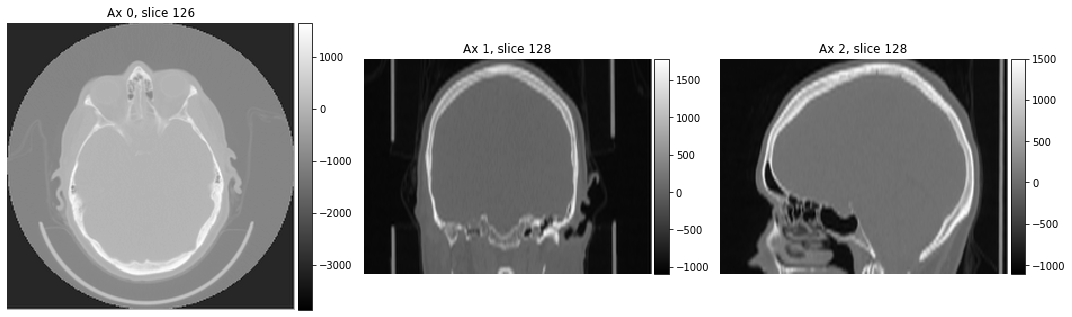

(<Figure size 1080x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f39caa49d90>,
       dtype=object))

In [65]:
# viz middle slices in each axis (sagittal, coronal, axial)

vol = reshaped_ct_vol 

ax0_idxs = [get_mid_idx(vol, ax=0)+30]
ax1_idxs = [get_mid_idx(vol, ax=1)]
ax2_idxs = [get_mid_idx(vol, ax=2)]

axes_idxs = [ax0_idxs, ax1_idxs, ax2_idxs]

ct_slices, ct_titles = get_slices(vol, axes_idxs)
ne.plot.slices(ct_slices, cmaps=['gray'], do_colorbars=True, grid=[1,3], titles=ct_titles)

# Load MR

In [72]:
ct_orientation = ct_obj.GetDirection()
ct_orientation

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [76]:
o_mr_obj        = sitk.ReadImage(mr_file)
o_mr_obj.SetDirection(ct_orientation)

o_mr_vol        = sitk.GetArrayFromImage(o_mr_obj)

In [78]:
o_mr_obj.GetDirection(), mr_obj.GetDirection()

((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 (0.9996102045738705,
  0.0,
  -0.027918432437759207,
  0.0,
  -1.0,
  0.0,
  0.02791843319000612,
  0.0,
  0.9996102045948803))

In [77]:
np.array_equal(o_mr_vol, mr_vol)

True

In [47]:

# Get path to MR file
mr_folder = f"{PROJ_PATH}/play"
mr_file = f"{mr_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# compile MR obj from nii file using Simple ITK reader
mr_obj        = sitk.ReadImage(mr_file)
mr_vol        = sitk.GetArrayFromImage(mr_obj)

print(f"mr vol shape: {mr_vol.shape}")
print(f"MR Metadata: ", *[(k, mr_obj.GetMetaData(k)) for k in mr_obj.GetMetaDataKeys()], sep="\n")

mr_vox_size = np.array(mr_obj.GetSpacing()[::-1]) # reverse array?
n_vox_size = np.mean(mr_vox_size)
iso_mr_vol = zoom(mr_vol, mr_vox_size/n_vox_size)[::-1] # reverse array?
print(f"Vox size: {mr_vox_size}, mean: {n_vox_size}.")
print(f"Isotropic (1,1,1)mm mr shape: {iso_mr_vol.shape}")

# rescale dimensions to (192, 256, 256)
vol_size = (192, 256, 256)

old_shape = np.array(iso_mr_vol.shape)
new_shape = np.array(vol_size)
reshaped_mr_vol = zoom(iso_mr_vol, new_shape/old_shape)

print(f"Reshaped mr vol (isotropic + reshaped) shape: {reshaped_mr_vol.shape}")

mr vol shape: (512, 480, 160)
MR Metadata: 
('ITK_FileNotes', '')
('ITK_original_direction', '[UNKNOWN_PRINT_CHARACTERISTICS]\n')
('ITK_original_spacing', '[UNKNOWN_PRINT_CHARACTERISTICS]\n')
('aux_file', '')
('bitpix', '16')
('cal_max', '0')
('cal_min', '0')
('datatype', '4')
('descrip', '')
('dim[0]', '3')
('dim[1]', '160')
('dim[2]', '480')
('dim[3]', '512')
('dim[4]', '1')
('dim[5]', '1')
('dim[6]', '1')
('dim[7]', '1')
('dim_info', '0')
('intent_code', '0')
('intent_name', '')
('intent_p1', '0')
('intent_p2', '0')
('intent_p3', '0')
('nifti_type', '1')
('pixdim[0]', '0')
('pixdim[1]', '1.2')
('pixdim[2]', '0.5')
('pixdim[3]', '0.5')
('pixdim[4]', '1')
('pixdim[5]', '1')
('pixdim[6]', '1')
('pixdim[7]', '1')
('qform_code', '1')
('qform_code_name', 'NIFTI_XFORM_SCANNER_ANAT')
('qoffset_x', '91.802')
('qoffset_y', '-79.3669')
('qoffset_z', '-137.258')
('quatern_b', '-0')
('quatern_c', '-0.999903')
('quatern_d', '-0')
('scl_inter', '0')
('scl_slope', '1')
('sform_code', '1')
('sform_c

In [79]:
nii_obj = nib.load(mr_file)
nii_arr = nii_obj.get_fdata(dtype=np.float32)
canon_nii_arr = nib.as_closest_canonical(nii_obj).get_fdata(dtype=np.float32)

In [80]:
np.array_equal(nii_arr, mr_vol)

False

In [82]:
nii_arr.shape, mr_vol.shape, canon_nii_arr.shape

((160, 480, 512), (512, 480, 160), (160, 480, 512))

In [89]:
interpolator = sitk.sitkLinear):
original_spacing = image.GetSpacing()
original_size = image.GetSize()

esample.SetInterpolator(sitk.sitkBSpline)

new_size = [int(round(osz*ospc)) for osz,ospc in zip(original_size, original_spacing)]

sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

In [96]:
sitk.Resample??

In [92]:
t1 = make_isotropic(ct_obj)

In [94]:
t1_arr = sitk.GetArrayFromImage(t1)

In [95]:
t1_arr.shape

(315, 512, 512)

In [85]:
orientation_filter = sitk.DICOMOrientImageFilter()
orientation_filter.SetDesiredCoordinateOrientation("LPS")
reoriented = orientation_filter.Execute(mr_vol)

TypeError: ignored

In [88]:
sitk.SetDesiredCoordinateOrientation()??

SyntaxError: ignored

In [83]:
reoriented = sitk.DICOMOrient(mr_vol, "LPS")

TypeError: ignored

In [84]:
sitk.DICOMOrient??

In [ ]:
np.array_equal(nii_arr, mr_vol)

In [ ]:
# Convert to RAS+ = canonical coords
nii_arr = nib.load(nii_file)
np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)


print(f"mr vol shape: {mr_vol.shape}")
print(f"MR Metadata: ", *[(k, mr_obj.GetMetaData(k)) for k in mr_obj.GetMetaDataKeys()], sep="\n")

mr_vox_size = np.array(mr_obj.GetSpacing()[::-1]) # reverse array?
n_vox_size = np.mean(mr_vox_size)
iso_mr_vol = zoom(mr_vol, mr_vox_size/n_vox_size)[::-1] # reverse array?
print(f"Vox size: {mr_vox_size}, mean: {n_vox_size}.")
print(f"Isotropic (1,1,1)mm mr shape: {iso_mr_vol.shape}")

# rescale dimensions to (192, 256, 256)
vol_size = (192, 256, 256)

old_shape = np.array(iso_mr_vol.shape)
new_shape = np.array(vol_size)
reshaped_mr_vol = zoom(iso_mr_vol, new_shape/old_shape)

print(f"Reshaped mr vol (isotropic + reshaped) shape: {reshaped_mr_vol.shape}")

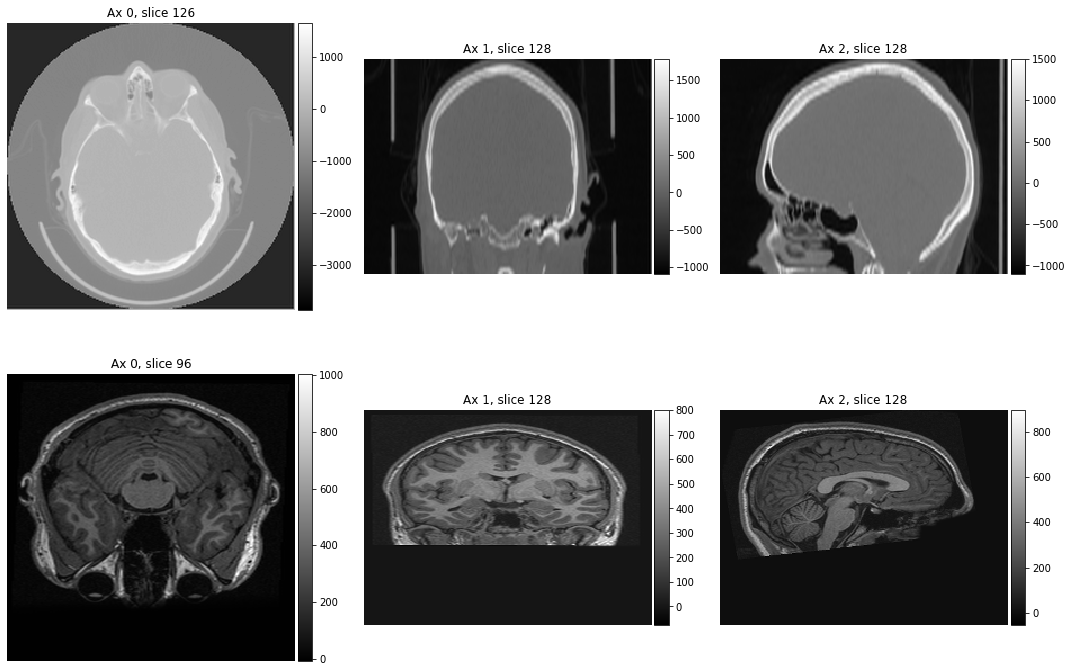

(<Figure size 1080x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39ca8bd890>,
       dtype=object))

In [66]:
# viz middle slices in each axis (sagittal, coronal, axial)


vol = reshaped_mr_vol 

ax0_idxs = [get_mid_idx(vol, ax=0)]
ax1_idxs = [get_mid_idx(vol, ax=1)]
ax2_idxs = [get_mid_idx(vol, ax=2)]

axes_idxs = [ax0_idxs, ax1_idxs, ax2_idxs]

mr_slices, mr_titles = get_slices(vol, axes_idxs)

ne.plot.slices(ct_slices + mr_slices, cmaps=['gray'], do_colorbars=True, grid=[2,3], titles=ct_titles + mr_titles)
#ne.plot.slices(mr_slices, cmaps=['gray'], do_colorbars=True, grid=[3,3], titles=mr_titles)

In [42]:
# mr metadata

# choose a MR (nii file)
mr_folder = f"{PROJ_PATH}/play"
mr_file = f"{mr_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# load file into MR obj
mr_obj  = nib.load(mr_file)
mr_vol  = mr_obj.get_fdata(dtype=np.float32)

# get binary mask associated w/ ROI
manual_mr_roi =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")

print(f"Manual mr ROI shape: {manual_mr_roi.shape}.")

print("MR coord system (original): ", nib.aff2axcodes(mr_obj.affine))
print(f"MR voxel cut sizes: {mr_obj.header['pixdim'][1:4]}")
print(f"MR image shape: {mr_vol.shape}")

# https://www.brainvoyager.com/bv/doc/UsersGuide/CoordsAndTransforms/ProcessingNIfTIFiles.html
# - the transformation matrix maps voxel coordinates to scanner world coordinates.
print("MR qform/sform code", mr_obj.header["qform_code"], mr_obj.header["sform_code"])

Manual mr ROI shape: (160, 480, 512).
MR coord system (original):  ('L', 'A', 'S')
MR voxel cut sizes: [1.2 0.5 0.5]
MR image shape: (160, 480, 512)
MR qform/sform code 1 1


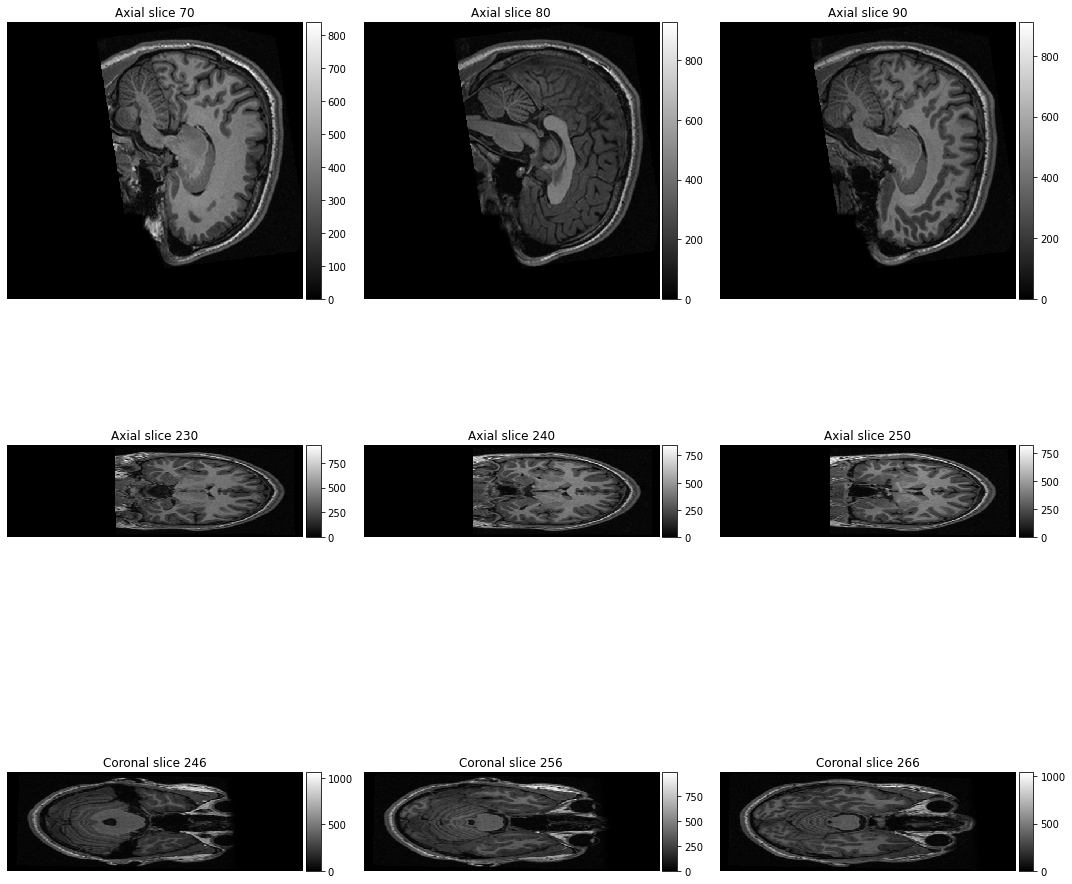

(<Figure size 1080x1080 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39cdfec850>,
       dtype=object))

In [45]:
# viz middle slices in each axis (sagittal, coronal, axial)

ras_mr_vol = nib.as_closest_canonical(mr_obj).get_fdata(dtype=np.float32)
vol = ras_mr_vol 

slices = []
titles = []

# axial slice
ax      = 0
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

# coronal slices
ax      = 1
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

# sagittal slices 
ax      = 2
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Coronal slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

ne.plot.slices(slices, cmaps=['gray'], do_colorbars=True, grid=[3,3], titles=titles)

In [ ]:
# resize isotropic + reshape

mr_vox_size = np.array(mr_obj.header['pixdim'][1:4][::-1]) # reverse array?
n_vox_size = np.mean(mr_vox_size)
iso_mr_vol = zoom(mr_vol, mr_vox_size/n_vox_size)[::-1] # reverse array?
print(f"Vox size: {mr_vox_size}, mean: {n_vox_size}.")
print(f"Isotropic (1,1,1)mm mr shape: {iso_mr_vol.shape}")

# rescale dimensions to (192, 256, 256)
vol_size = (192, 256, 256)

old_shape = np.array(iso_mr_vol.shape)
new_shape = np.array(vol_size)
reshaped_mr_vol = zoom(iso_mr_vol, new_shape/old_shape)

print(f"Reshaped mr vol (isotropic + reshaped) shape: {reshaped_mr_vol.shape}")

In [ ]:
# viz middle slices in each axis (sagittal, coronal, axial)

vol = reshaped_ct_vol 

slices = []
titles = []

# axial slice
ax      = 0
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

# coronal slices
ax      = 1
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

# sagittal slices 
ax      = 2
mid_idx = vol.shape[ax]//2
idxs    = (mid_idx - 10, mid_idx, mid_idx + 10)
titles += [f"Coronal slice {i}" for i in idxs]
slices += [np.take(vol, i, axis=ax) for i in idxs]

ne.plot.slices(slices, cmaps=['gray'], do_colorbars=True, grid=[3,3], titles=titles)

In [38]:
# get binary mask associated w/ ROI
# moving_mr  =  np.load(f"{PROJ_PATH}/dicom_img_numpy_array.npy")
manual_mr_roi =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")

print(f"Manual mr ROI shape: {manual_mr_roi.shape}.")

Manual mr ROI shape: (160, 480, 512)


In [ ]:
#

In [ ]:
# from skimage.transform import resize
# bicubic preferred, otherwise bilinear for fast
# segmentation_volume = resize(segmentation_volume, output_shape = output_shape, order = interp_order)

In [ ]:
# print(nii_vol)

# Resize

Isotropic:
- make slices [1mm 1mm 1mm]
- bicubic interpolation

Original:
- CT is [0.5 0.5 2.5] (mm)
- MR is [1.2 0.5 0.5] (mm)

In [ ]:
ct_obj.header.get_zooms()

(0.492188, 0.492188, 2.5)

In [ ]:
# Slice thickness
print(f"CT slice thickness: {ct_obj.header.get_zooms()}")
print(f"MR slice thickness: {mr_obj.header.get_zooms()}")

CT slice thickness: (0.492188, 0.492188, 2.5)
MR slice thickness: (1.2, 0.5, 0.5)


### CT

In [ ]:
import os
from operator import attrgetter, itemgetter
from collections import defaultdict, OrderedDict
import pydicom as pyd

# Get path to dcm files
ct_ds_name = "manifest-1614720733774/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-039/01-11-1960-PET RESEARCH-94533/3.000000-CT 2.5MM STD-12405"
ct_folder = os.path.join(PROJ_PATH, ct_ds_name)
ct_paths = [os.path.join(ct_folder, ct_file) for ct_file in os.listdir(ct_folder)]
print(f"CT folder has:  {len(ct_paths)} files.")

# Sort dcm files by SliceLocation
get_attrs = attrgetter("SliceLocation", "pixel_array", "PixelSpacing", "SliceThickness")
ct_slices = [get_attrs(pyd.dcmread(ct_path)) for ct_path in ct_paths]

# change string to float for slice thickness
ct_slices = [(float(loc),arr,spacing, float(thickness)) for (loc,arr,spacing,thickness) in ct_slices]

# sort slices by slice location
ct_slices.sort(key=itemgetter(0))

# Concatenate python list of slices into numpy array
manual_ct_vol = np.concatenate([np.expand_dims(ct_slice[1], axis = 0) for ct_slice in ct_slices])
print(f"CT vol has shape {manual_ct_vol.shape}.")

CT folder has:  62 files.
CT vol has shape (62, 512, 512).


In [ ]:
# pyd.dcmread(ct_paths[0]).PixelSpacing

In [ ]:
ct_slices[0]

(-162.9, array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        ...,
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16), [0.492188, 0.492188], 2.5)

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 84kB/s 


In [ ]:
# from https://www.kaggle.com/kmader/voxelmorph-on-ct-data

# image code
import SimpleITK as sitk
from scipy.ndimage import zoom
from mpl_toolkits.mplot3d import axes3d
# third party
import tensorflow as tf
import scipy.io as sio

from scipy.interpolate import interpn


def load_dicom_stack(in_folder):
    """read and make isotropic"""
    series_reader = sitk.ImageSeriesReader()
    cur_paths = series_reader.GetGDCMSeriesFileNames(in_folder)
    print(cur_paths[0])
    c_img = sitk.ReadImage(cur_paths)
    print([c_img.GetMetaData(k) for k in c_img.GetMetaDataKeys()])
    c_vox_size = np.array(c_img.GetSpacing()[::-1])
    c_arr = sitk.GetArrayFromImage(c_img)
    print(c_vox_size, c_arr.shape)
    n_vox_size = np.mean(c_vox_size)
    n_arr = zoom(c_arr, c_vox_size/n_vox_size)
    print(n_vox_size, n_arr.shape)
    return n_arr[::-1]

In [ ]:
vxm_ct_vol = load_dicom_stack(ct_folder)

/content/drive/My Drive/PitProj/manifest-1614720733774/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-039/01-11-1960-PET RESEARCH-94533/3.000000-CT 2.5MM STD-12405/1-62.dcm
['[UNKNOWN_PRINT_CHARACTERISTICS]\n']
[2.5      0.492188 0.492188] (62, 512, 512)
1.1614586666666666 (133, 217, 217)


In [ ]:
vxm_ct_vol.shape

(133, 217, 217)

In [ ]:
# from https://www.kaggle.com/akh64bit/full-preprocessing-tutorial
def resample(image, ct_folder, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([])
        
        map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

TypeError: ignored

In [ ]:
import os
from operator import attrgetter, itemgetter
from collections import defaultdict, OrderedDict
import pydicom as pyd

# Get path to dcm files
ct_ds_name = "manifest-1614720733774/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-039/01-11-1960-PET RESEARCH-94533/3.000000-CT 2.5MM STD-12405"
ct_folder = os.path.join(PROJ_PATH, ct_ds_name)
ct_paths = [os.path.join(ct_folder, ct_file) for ct_file in os.listdir(ct_folder)]
print(f"CT folder has:  {len(ct_paths)} files.")

# Sort dcm files by SliceLocation
ct_slices = [attrgetter("SliceLocation", "pixel_array")(pyd.dcmread(ct_path)) for ct_path in ct_paths]
ct_slices.sort(key=itemgetter(0))

# Concatenate python list of slices into numpy array
manual_ct_vol = np.concatenate([np.expand_dims(ct_slice, axis = 0) for (_,ct_slice) in ct_slices])
print(f"CT vol has shape {manual_ct_vol.shape}.")

In [ ]:
import scipy

# from https://www.kaggle.com/akh64bit/full-preprocessing-tutorial
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

In [ ]:
from scipy.ndimage import zoom

In [ ]:
n_arr = zoom(c_arr, c_vox_size/n_vox_size)

# Data

1. Load moving image, fixed image (= CT scan or MR atlas).
2. Match orientation
2. Resize to same slice thickness (voxel resolution) and spacing between voxels
3. Intensity normalize to have same distribution between moving and fixed image
4. Affinely align (is this necessary as pre-processing step?)

## Fixed image

In [ ]:
# import

# choose a nii file
nii_folder = f"{PROJ_PATH}/play"
nii_file = f"{nii_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# get the underlying MR in RAS+ = canonical coords
nii_vol    = nib.load(nii_file)
nii_np_arr = nii_vol.get_fdata(dtype=np.float32)

print("NifTi coord system (original): ", nib.aff2axcodes(nii_arr.affine))
print(f"Nii shape: {nii_np_arr.shape}")
print(f"Voxel cut sizes: {nii_vol.header['pixdim'][1:4]}")

# Convert to RAS+ = canonical coords
# np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)
# print("MR shape: ", np_arr.shape, " (axial, sagittal, coronal)")

NameError: ignored

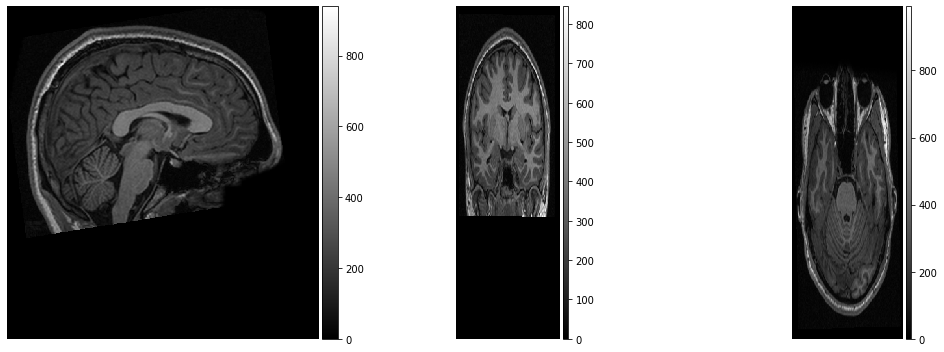

In [ ]:
# quickly viz mid slice

nii_mid_slices = [np.take(np_arr, np_arr.shape[d]//2, axis=d) for d in range(3)]
nii_mid_slices[0] = np.rot90(nii_mid_slices[0], 1) # sagittal
nii_mid_slices[1] = np.rot90(nii_mid_slices[1], 1) # coronal
nii_mid_slices[2] = np.rot90(nii_mid_slices[2], 1) # axial

ne.plot.slices(nii_mid_slices, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

In [ ]:
ne.plot.slices

Nifti input has 512 axial slices.


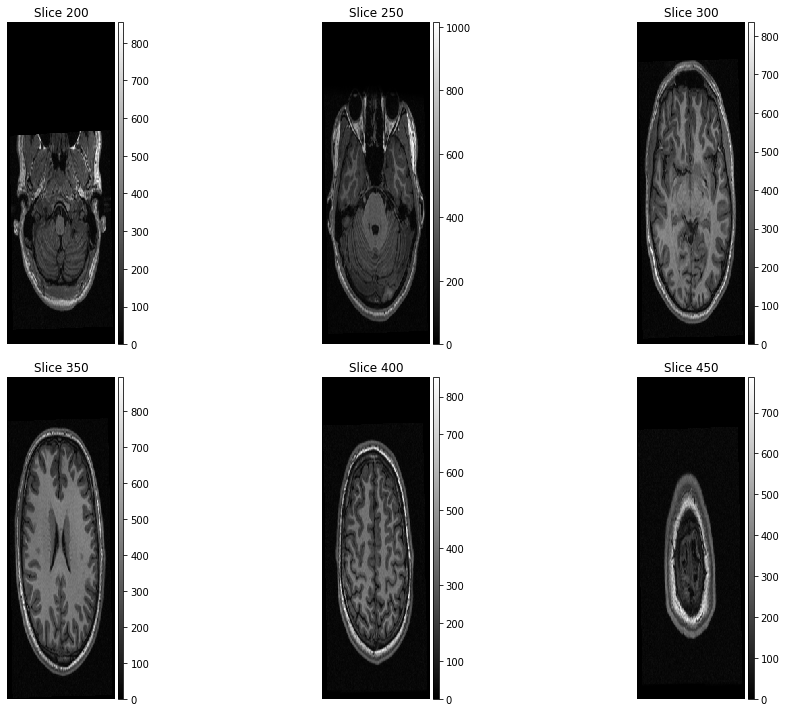

In [ ]:
# viz axial
print(f"Nifti input has {nii_np_arr.shape[2]} axial slices.")

axial_slice_idxs = (200,250,300,350, 400, 450)
titles = [f"Slice {idx}" for idx in axial_slice_idxs]

axial_slices = [np.rot90(np.take(nii_np_arr, idx, axis=2), 1) for idx in axial_slice_idxs]
ne.plot.slices(axial_slices, cmaps=['gray'], do_colorbars=True, grid=[2,3], titles = titles);

## MR atlas

In [ ]:
# MR atlas from https://github.com/voxelmorph/voxelmorph/tree/master/data/

atlas  =  np.load(f"{PROJ_PATH}/atlas.npz")
labels =  np.load(f"{PROJ_PATH}/labels.npz")

atlas_vol = atlas["vol"]
atlas_seg = atlas["seg"]

labels = labels["labels"]

atlas_vol_shape = atlas_vol.shape # include slices?

print(f"atlas shape {atlas_vol.shape}, num labels = {len(labels)}")

atlas shape (160, 192, 224), num labels = 30


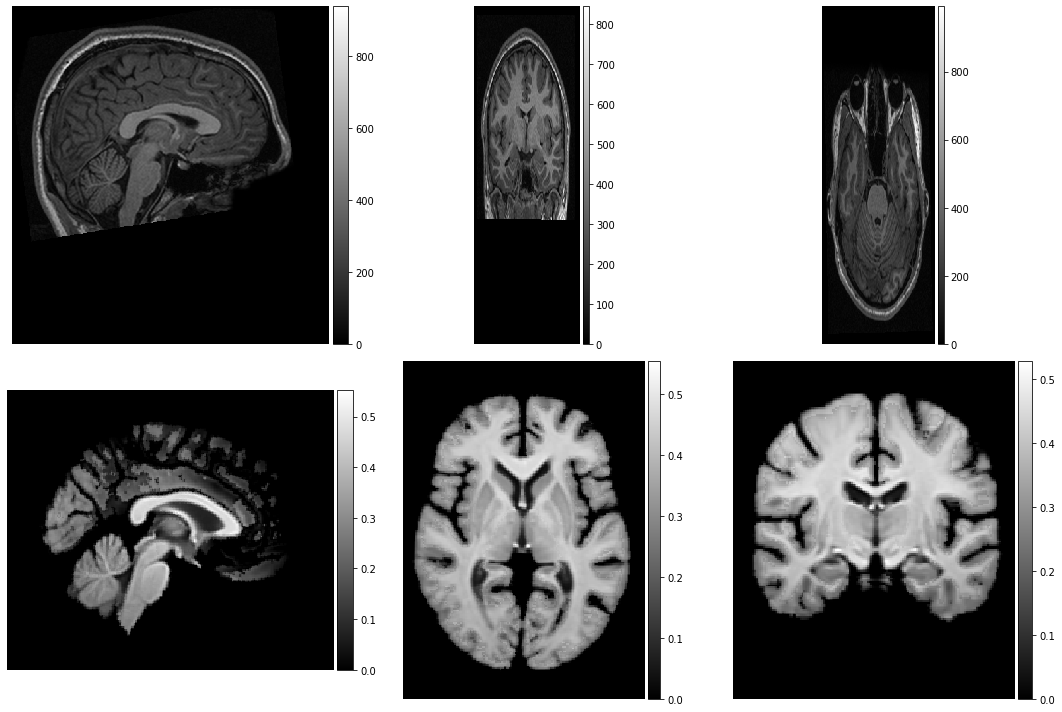

In [ ]:
nii_mid_slices_fixed = [np.take(np_arr, np_arr.shape[d]//2, axis=d) for d in range(3)]
nii_mid_slices_fixed[0] = np.rot90(nii_mid_slices_fixed[0], 1) # sagittal
nii_mid_slices_fixed[1] = np.rot90(nii_mid_slices_fixed[1], 1) # coronal
nii_mid_slices_fixed[2] = np.rot90(nii_mid_slices_fixed[2], 1) # axial

slices = (atlas_vol.shape[0]//2, atlas_vol.shape[1]//2, )
atlas_mid_slices_fixed = [np.take(atlas_vol, atlas_vol.shape[d]//2, axis=d) for d in range(3)]
atlas_mid_slices_fixed[1] = np.rot90(atlas_mid_slices_fixed[1], 1)
atlas_mid_slices_fixed[2] = np.rot90(atlas_mid_slices_fixed[2], -1)

ne.plot.slices(nii_mid_slices_fixed + atlas_mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

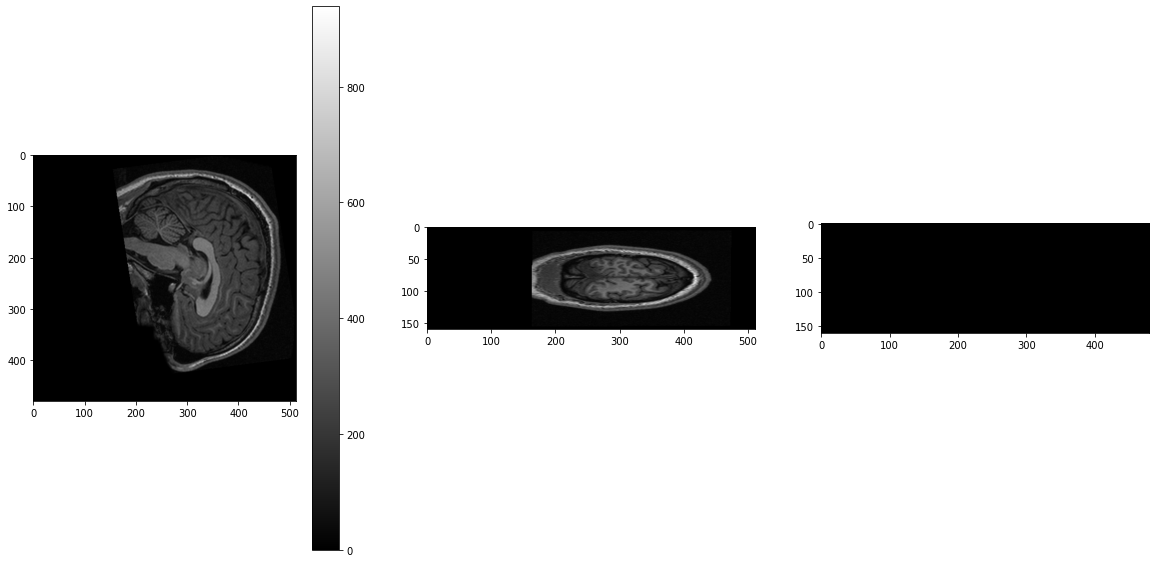

In [ ]:
import matplotlib.pyplot as plt

idx = 80

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
im1 = ax1.imshow(np_arr[idx], cmap='gray')
im2 = ax2.imshow(np_arr[:,idx,:], cmap='gray')
im3 = ax3.imshow(np_arr[:,:,idx], cmap='gray')

fig.colorbar(im1, ax=ax1)

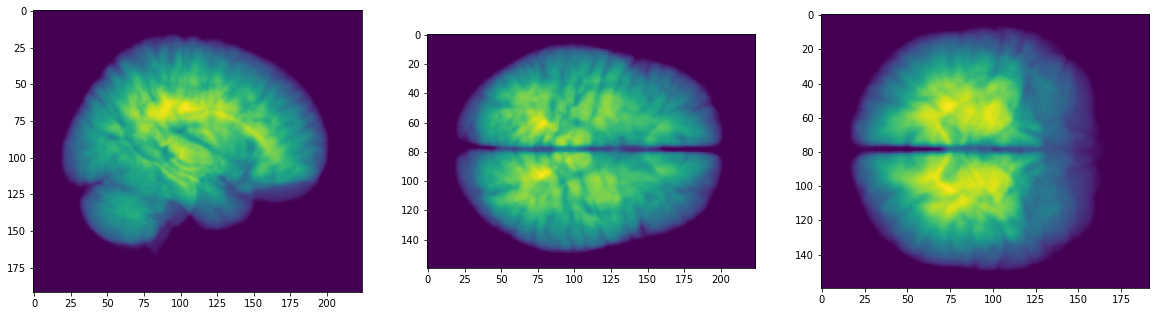

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

In [ ]:
nii_arr.shape

(160, 480, 512)

### Atlas stats

Source: https://www.kaggle.com/kmader/voxelmorph-on-ct-data#Load-Atlas-Data

In [ ]:
# atlas has many 0 values, remove this mass in calc
def get_stats(vol, include_zero=True): 
  if include_zero: return vol.min(), vol.max(), vol.mean(), vol.std()
  return vol.min(), vol.max(), vol[vol>0].mean(), vol[vol>0].std()

def print_stats(min, max, mean, std): print(f"min: {min:.2f}, max: {max:.2f}, mean = {mean:.2f}, std = {std:.2f}")

min: 0.00, max: 0.73, mean = 0.29, std = 0.12


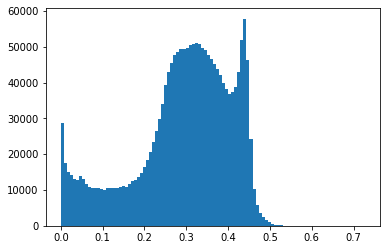

In [ ]:
atlas_min, atlas_max, atlas_mean, atlas_std = get_stats(atlas_vol, include_zero=False)
print_stats(atlas_min, atlas_max, atlas_mean, atlas_std)

plt.hist(atlas_vol[atlas_vol>0], 100);

## viz atlas

Source: https://www.kaggle.com/kmader/voxelmorph-demo

In [ ]:
import matplotlib.pyplot as plt

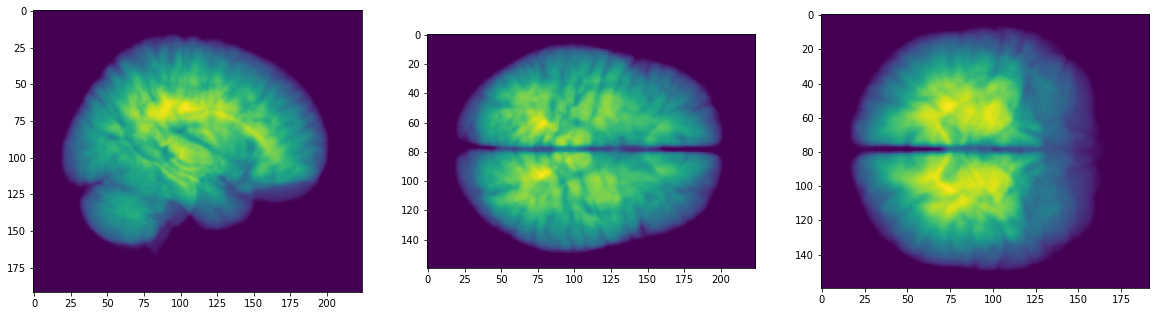

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

NameError: ignored

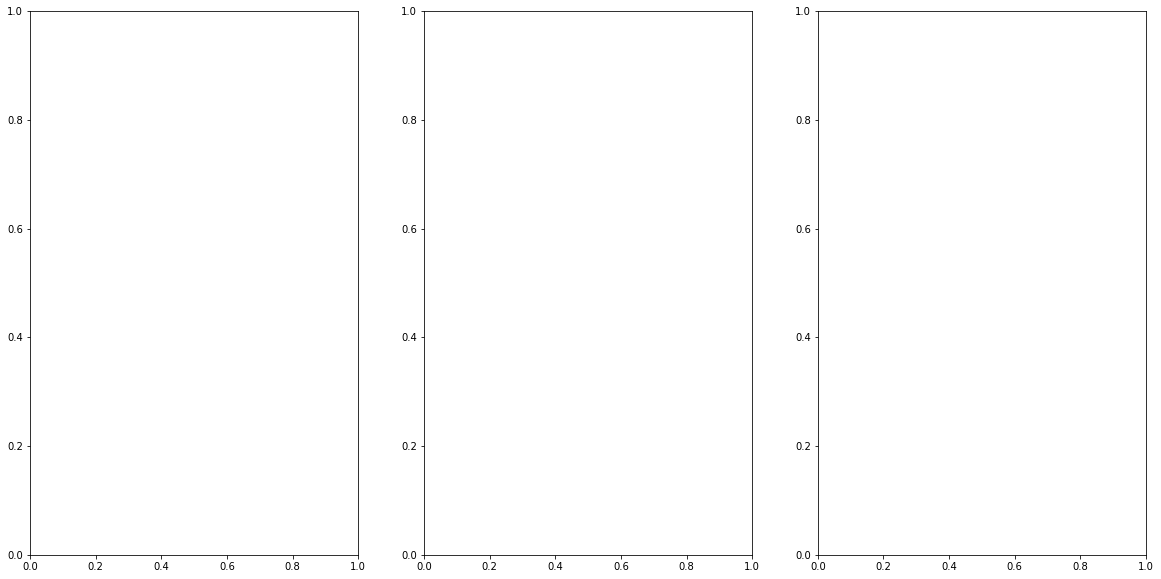

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

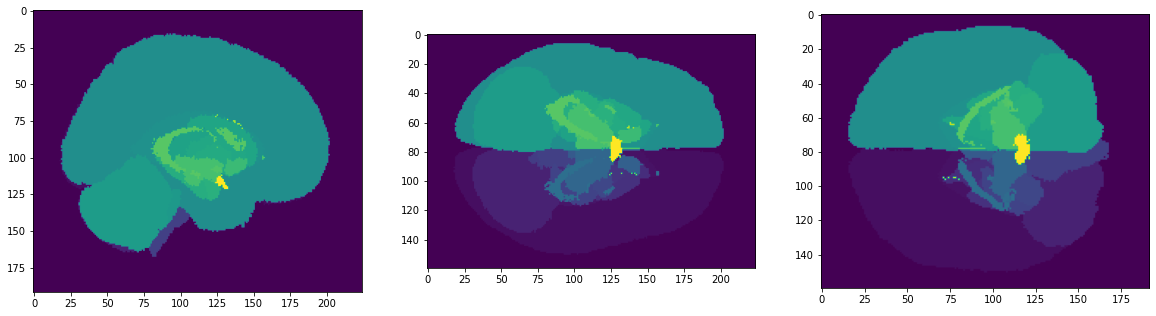

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(atlas_seg, 0))
ax2.imshow(np.max(atlas_seg, 1))
ax3.imshow(np.max(atlas_seg, 2))

In [ ]:
print(atlas_vol.shape, atlas_vol.min(), atlas_vol[atlas_vol>0].mean(), atlas_vol[atlas_vol>0].std(), atlas_vol.max())
plt.hist(atlas_vol[atlas_vol>0], 100);

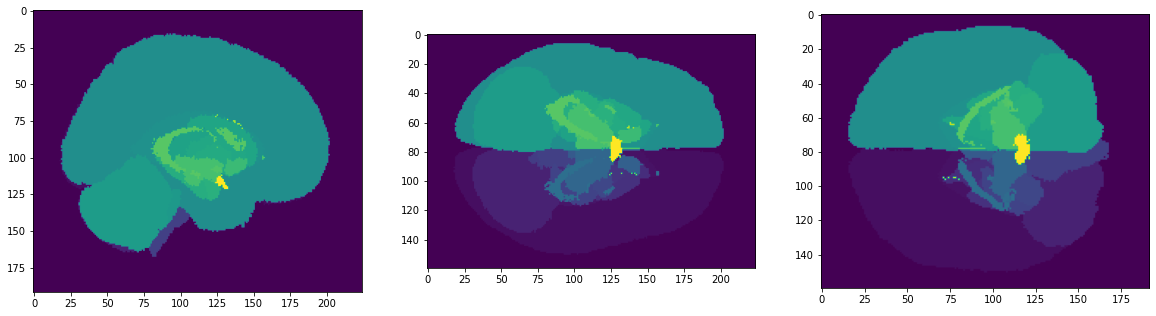

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(vxm_atlas_seg, 0))
ax2.imshow(np.max(vxm_atlas_seg, 1))
ax3.imshow(np.max(vxm_atlas_seg, 2))

## Moving image

In [ ]:
# get binary mask associated w/ ROI
moving_mr  =  np.load(f"{PROJ_PATH}/dicom_img_numpy_array.npy")
manual_roi =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")

print(f"moving mr shape: {moving_mr.shape}. manual roi: {manual_roi.shape}")

moving mr shape: (160, 480, 512). manual roi: (160, 480, 512)


min: 0.00, max: 1140.00, mean = 151.65, std = 148.42


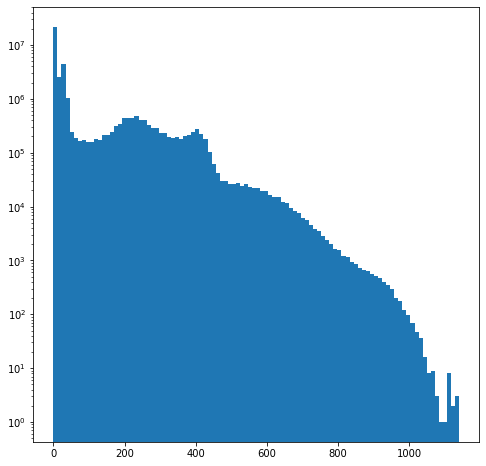

In [ ]:
moving_mr_min, moving_mr_max, moving_mr_mean, moving_mr_std = get_stats(moving_mr, include_zero=False)
print_stats(moving_mr_min, moving_mr_max, moving_mr_mean, moving_mr_std)

fig, ax1 = plt.subplots(1,1,figsize = (8, 8))
ax1.hist(moving_mr.ravel(), 100, log = True);

# viz

In [ ]:
sag = np.swapaxes(moving_mr,0,1)

In [ ]:
sag.shape

(480, 160, 512)

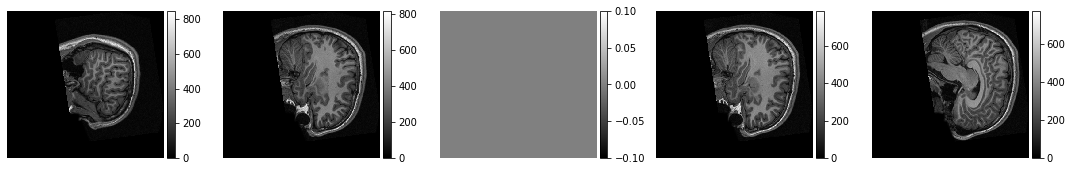

In [ ]:
# extract some brains
nb_vis = 5
x_train = moving_mr

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

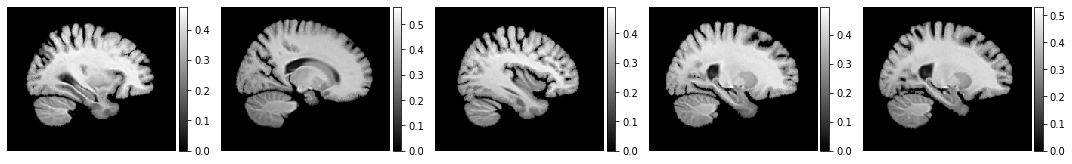

In [ ]:
# extract some brains
nb_vis = 5
x_train = atlas_vol

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# Rescale 

Rescale input to atlas distribution  (intensity and shape) 

In [ ]:
from scipy.ndimage import zoom

def rescale_vol(in_vol):
    """rescale to atlas intensity and make dimensions correct"""
    n_vol = (((np.clip(in_vol, moving_mr_min, moving_mr_max)-moving_mr_mean)/moving_mr_std)*atlas_std+atlas_mean)
    old_shape = np.array(n_vol.shape)
    new_shape = np.array(atlas_vol_shape)
    return zoom(n_vol, new_shape/old_shape)

In [ ]:
# resize to MR atlas shape = 192 z 224
rescaled_moving_mr = rescale_vol(moving_mr)

# print stats
print("Rescaled shape: ", rescaled_moving_mr.shape)
print("Atlas shape: ", atlas_vol_shape)

print("Rescaled stats: ")
print_stats(*get_stats(rescaled_moving_mr))

print("Atlas stats: ")
print_stats(atlas_min, atlas_max, atlas_mean, atlas_std)

Rescaled shape:  (160, 192, 224)
Atlas shape:  (160, 192, 224)
Rescaled stats: 
min: 0.00, max: 1.08, mean = 0.22, std = 0.10
Atlas stats: 
min: 0.00, max: 0.73, mean = 0.29, std = 0.12


(None, None)

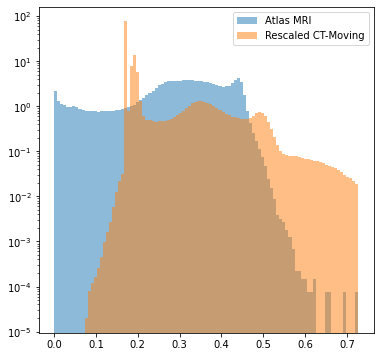

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize = (6, 6))

out_vals = ax1.hist(atlas_vol[atlas_vol>0], 100, label = 'Atlas MRI', alpha = 0.5, density=True, log = True)
ax1.hist(rescaled_moving_mr.ravel(), out_vals[1], label = 'Rescaled CT-Moving', alpha = 0.5, density=True, log = True)
ax1.legend()

### Model

In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = atlas_vol_shape
nb_features = [
    [16, 32, 32, 32], # encoder
    [32, 32, 32, 32, 32, 16, 16] # decoder
]

In [ ]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

### Validation data

Let's prepare our validation data.

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

# val_input = [
#     val_volume_1[np.newaxis, ..., np.newaxis],
#     val_volume_2[np.newaxis, ..., np.newaxis]
# ]

val_input = [
    rescaled_moving_mr[np.newaxis, ..., np.newaxis],
    atlas_vol[np.newaxis, ..., np.newaxis]
]

In [ ]:
val_volume_1.shape, seg_volume_1.shape

((160, 192, 224), (160, 192, 224))

In [ ]:
val_input[0].shape, val_input[1].shape

((1, 160, 192, 224, 1), (1, 160, 192, 224, 1))

In [ ]:
# extract some brains
nb_vis = 5
x_train = rescaled_moving_mr[:,[2,0,1]]

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

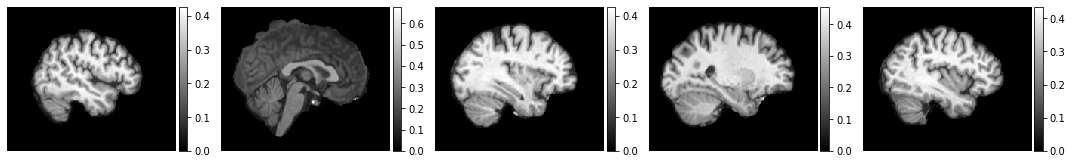

In [ ]:
# extract some brains
nb_vis = 5
x_train = val_volume_1

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Load a trained 3D model.

In [ ]:
vxm_model.load_weights('brain_3d.h5')

Now let's register.

In [ ]:
val_pred = vxm_model.predict(val_input);

In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

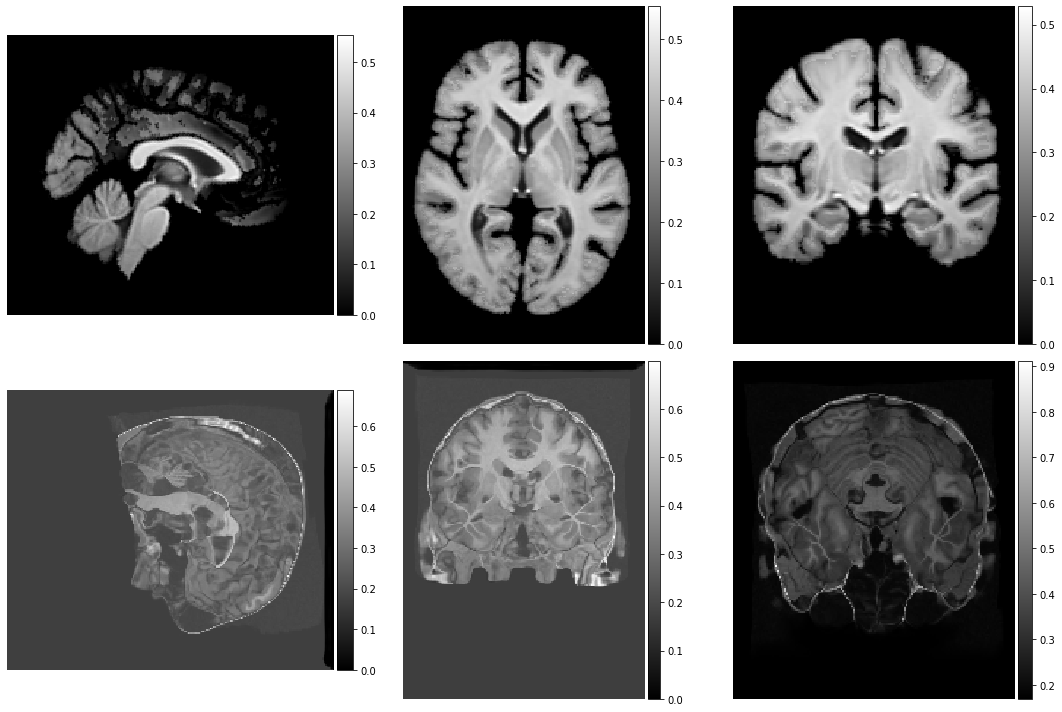

In [ ]:
mid_slices_fixed = [np.take(atlas_vol, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

In [ ]:
n_vol = zoom(n_vol, new_shape/old_shape)

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2021-02-28 19:33:39--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16643404 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  15.3MB/s    in 1.0s    

2021-02-28 19:33:41 (15.3 MB/s) - ‘data.tar.gz’ saved [16643404/16643404]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
vxm_atlas_vol.shape

(160, 192, 224)

In [ ]:
vxm_atlas_seg.shape

(160, 192, 224)

In [ ]:
val_volume_2 = np.load('atlas.npz')['vol']
seg_volume_2 = np.load('atlas.npz')['seg']

ValueError: ignored

In [ ]:
np.load('atlas.npz', allow_pickle=True,fix_imports=True,encoding='latin1')

OSError: ignored